In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
%pip install joblib==1.1.1
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
all_df_5steps = pd.read_csv("TrainingData_5.csv",index_col=False)
all_df_15steps = pd.read_csv("TrainingData_15.csv",index_col=False)

False    238683
True       6329
Name: WarningIndication, dtype: int64

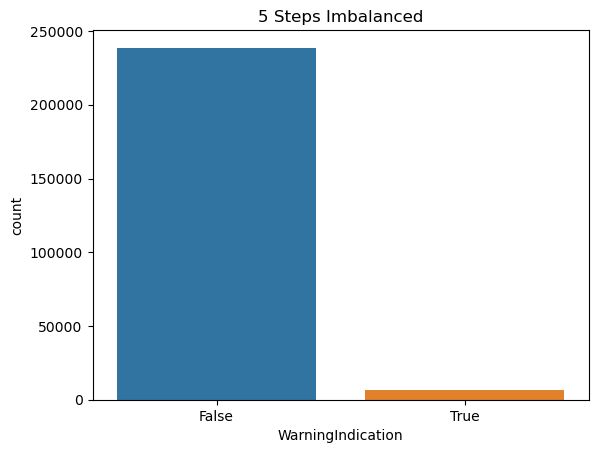

In [3]:
sns.countplot(x="WarningIndication", data=all_df_5steps).set(title="5 Steps Imbalanced")
all_df_5steps['WarningIndication'].value_counts()

False    238683
True       6329
Name: WarningIndication, dtype: int64

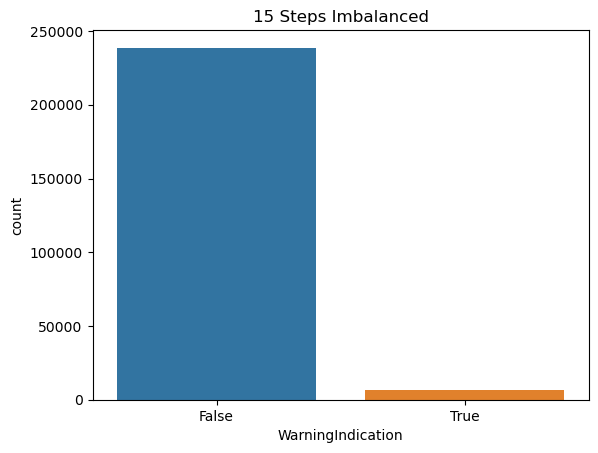

In [4]:
sns.countplot(x="WarningIndication", data=all_df_15steps).set(title="15 Steps Imbalanced")
all_df_15steps['WarningIndication'].value_counts()

In [5]:
minority_class_5steps = all_df_5steps[all_df_5steps["WarningIndication"] == True]
majority_class_5steps = all_df_5steps[all_df_5steps["WarningIndication"] == False]
minority_class_15steps = all_df_15steps[all_df_15steps["WarningIndication"] == True]
majority_class_15steps = all_df_15steps[all_df_15steps["WarningIndication"] == False]
column_name = all_df_5steps.columns

In [6]:
from sklearn.utils import resample
downsampled_majority_5steps = resample(majority_class_5steps,
                                replace=False, 
                                n_samples=len(minority_class_5steps),  
                                random_state=7)  
down_sampled_5steps = np.vstack((downsampled_majority_5steps, minority_class_5steps))
down_sampled_5steps = pd.DataFrame(down_sampled_5steps).sample(frac = 1)

In [7]:
downsampled_majority_15steps = resample(majority_class_15steps,
                                replace=False, 
                                n_samples=len(minority_class_15steps),  
                                random_state=7)  
down_sampled_15steps = np.vstack((downsampled_majority_15steps, minority_class_15steps))
down_sampled_15steps = pd.DataFrame(down_sampled_15steps).sample(frac = 1)

[Text(0.5, 1.0, '5 Steps Balanced (After Undersampling)')]

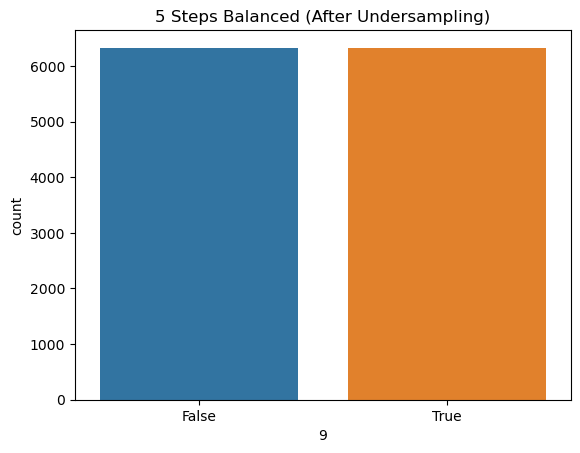

In [8]:
sns.countplot(x=9, data=down_sampled_5steps).set(title="5 Steps Balanced (After Undersampling)")

[Text(0.5, 1.0, '15 Steps Balanced (After Undersampling)')]

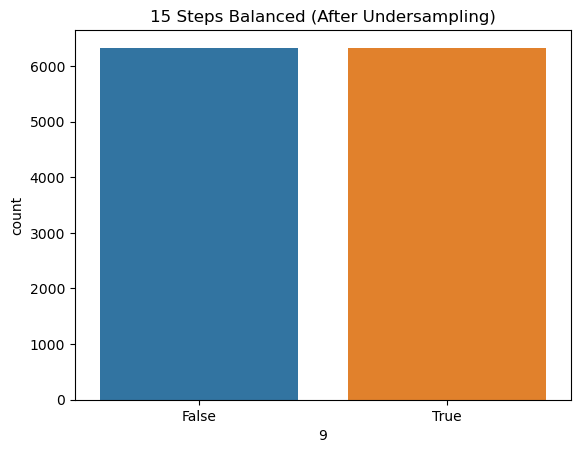

In [9]:
sns.countplot(x=9, data=down_sampled_15steps).set(title="15 Steps Balanced (After Undersampling)")

In [10]:
def convert(x):
  if x:
    return 1
  else: 
    return 0

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
X_5steps = down_sampled_5steps.drop(9, axis=1)
y_5steps = down_sampled_5steps[9]
X_15steps = down_sampled_15steps.drop(9,axis=1)
y_15steps = down_sampled_15steps[9]

In [12]:
Xs_train_5, Xs_test_5, y_train_5, y_test_5 = train_test_split(X_5steps,y_5steps,test_size=0.3,random_state=0)
Xs_train_15, Xs_test_15, y_train_15, y_test_15 = train_test_split(X_15steps,y_15steps,test_size=0.3,random_state=0)
y_train_5 = y_train_5.map(convert)
y_test_5 = y_test_5.map(convert)
y_train_15 = y_train_15.map(convert)
y_test_15 = y_test_15.map(convert)
scoring_metric = {
    'accuracy':'accuracy',
    'precision' : make_scorer(precision_score),
    'f1_score' : make_scorer(f1_score),
    'recall' : make_scorer(recall_score)
}

In [ ]:
def parameterTuning(model,param_grid,train_x,train_y):
  optimal_params = GridSearchCV(
      model,
      param_grid,
      cv=5,
      scoring=scoring_metric,
      refit='f1_score')
  optimal_params.fit(train_x,train_y)
  return optimal_params

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate(y_true,y_hat,mode):
  acc = accuracy_score(y_true,y_hat)
  f1 = f1_score(y_true, y_hat)
  print(f"Accuracy ({mode}) =" ,acc*100)
  print(f"F1 Score ({mode}) =",f1)

# **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid=[
    {'C': [0.5,1,1.5],
    'gamma':['scale',1,0.1,'auto'],
    'kernel':['rbf','linear','poly']},
]
optimal_params_5 = parameterTuning(SVC(),param_grid,Xs_train_5,y_train_5)
print(optimal_params_5.best_params_)
optimal_params_15 = parameterTuning(SVC(),param_grid,Xs_train_15,y_train_15)
print(optimal_params_15.best_params_)


{'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
# 5 Steps
svc = optimal_params_5.best_estimator_
filename="SVC_5steps"
joblib.dump(svc, filename)
prediction = svc.predict(Xs_test_5)
train = svc.predict(Xs_train_5)
evaluate(y_train_5,train, "train")
evaluate(y_test_5,prediction, "test")
print(confusion_matrix(y_test_5,prediction))

Accuracy (train) = 76.6704288939052
F1 Score (train) = 0.7804567180031864
Accuracy (test) = 76.54028436018957
F1 Score (test) = 0.7760743905503894
[[1363  575]
 [ 316 1544]]


In [ ]:
# 15 Steps
svc = optimal_params_15.best_estimator_
filename="SVC_15steps"
joblib.dump(svc, filename)
prediction = svc.predict(Xs_test_15)
train = svc.predict(Xs_train_15)
evaluate(y_train_15,train,"train")
evaluate(y_test_15,prediction,"test")
print(confusion_matrix(y_test_15,prediction))

Accuracy (train) = 66.8058690744921
F1 Score (train) = 0.6999285787164574
Accuracy (test) = 67.95681937862032
F1 Score (test) = 0.7122251123196973
[[1075  811]
 [ 406 1506]]


# **Neural Network**

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42,activation='relu')
param_grid=[
    {'hidden_layer_sizes': [(5,), (10,), (20,), (50,)],
     'max_iter':[1000,1500,2000]}
]
optimal_params_5 = parameterTuning(mlp,param_grid,Xs_train_5,y_train_5)
print(optimal_params_5.best_params_)
optimal_params_15 = parameterTuning(mlp,param_grid,Xs_train_15,y_train_15)
print(optimal_params_15.best_params_)

{'hidden_layer_sizes': (50,), 'max_iter': 1000}
{'hidden_layer_sizes': (50,), 'max_iter': 1000}


In [ ]:
# 5 Steps
mlp = optimal_params_5.best_estimator_
y_hat_test = mlp.predict(Xs_test_5)
y_hat_train = mlp.predict(Xs_train_5)
filename="MLP_5steps"
joblib.dump(mlp, filename)
evaluate(y_train_5,y_hat_train,"train")
evaluate(y_test_5,y_hat_test,"test")
print(confusion_matrix(y_test_5,y_hat_test))

Accuracy (train) = 77.09932279909707
F1 Score (train) = 0.7832033336894967
Accuracy (test) = 76.93522906793049
F1 Score (test) = 0.7786760990399191
[[1381  557]
 [ 319 1541]]


In [ ]:
# 15 Steps
mlp = optimal_params_15.best_estimator_
y_hat_test = mlp.predict(Xs_test_15)
y_hat_train = mlp.predict(Xs_train_15)
filename="MLP_15steps"
joblib.dump(mlp, filename)
evaluate(y_train_15,y_hat_train,"train")
evaluate(y_test_15,y_hat_test,"test")
print(confusion_matrix(y_test_15,y_hat_test))

Accuracy (train) = 66.63656884875846
F1 Score (train) = 0.6813968527699935
Accuracy (test) = 67.37756714060032
F1 Score (test) = 0.6924795234549516
[[1164  722]
 [ 517 1395]]


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
param_grid=[
    {'n_estimators': [100,200,300,400,500],
     'max_depth':[7,8,9,10],
     'criterion':['gini', 'entropy', 'log_loss']}
]
optimal_params_5 = parameterTuning(rf,param_grid,Xs_train_5,y_train_5)
print(optimal_params_5.best_params_)
optimal_params_15 = parameterTuning(rf,param_grid,Xs_train_15,y_train_15)
print(optimal_params_15.best_params_)

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 100}
{'criterion': 'log_loss', 'max_depth': 7, 'n_estimators': 300}


In [ ]:
# 5 Steps
rf = optimal_params_5.best_estimator_
filename="RF_5steps"
joblib.dump(rf, filename)
y_hat_train = rf.predict(Xs_train_5)
y_hat_test = rf.predict(Xs_test_5)
evaluate(y_train_5,y_hat_train,"train")
evaluate(y_test_5,y_hat_test,"test")
print(confusion_matrix(y_test_5,y_hat_test))

Accuracy (train) = 82.57336343115124
F1 Score (train) = 0.8205902858470834
Accuracy (test) = 81.54291732490785
F1 Score (test) = 0.8073646606210497
[[1628  310]
 [ 391 1469]]


In [ ]:
# 15 Steps
rf = optimal_params_15.best_estimator_
filename="RF_15steps"
joblib.dump(rf, filename)
y_hat_train = rf.predict(Xs_train_15)
y_hat_test = rf.predict(Xs_test_15)
evaluate(y_train_15,y_hat_train,"train")
evaluate(y_test_15,y_hat_test,"test")
print(confusion_matrix(y_test_15,y_hat_test))

Accuracy (train) = 71.80586907449211
F1 Score (train) = 0.724647266313933
Accuracy (test) = 70.45813586097947
F1 Score (test) = 0.7146490335707019
[[1271  615]
 [ 507 1405]]


# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
param_grid={'criterion':['gini','log_loss','entropy'],
            'max_depth':[5,6,7,8,9,10]}
optimal_params_5 = parameterTuning(dt,param_grid,Xs_train_5,y_train_5)
print(optimal_params_5.best_params_)
optimal_params_15 = parameterTuning(dt,param_grid,Xs_train_15,y_train_15)
print(optimal_params_15.best_params_)

{'criterion': 'log_loss', 'max_depth': 5}
{'criterion': 'log_loss', 'max_depth': 5}


In [ ]:
# 5 Steps
dt = optimal_params_5.best_estimator_
filename="DT_5steps"
joblib.dump(dt, filename)
y_hat_train = dt.predict(Xs_train_5)
y_hat_test = dt.predict(Xs_test_5)
evaluate(y_train_5,y_hat_train,"train")
evaluate(y_test_5,y_hat_test,"test")
print(confusion_matrix(y_test_5,y_hat_test))

Accuracy (train) = 81.36568848758465
F1 Score (train) = 0.80248833592535
Accuracy (test) = 80.80568720379146
F1 Score (test) = 0.7926031294452347
[[1676  262]
 [ 467 1393]]


In [ ]:
# 15 Steps
dt = optimal_params_15.best_estimator_
filename="DT_15steps"
joblib.dump(dt, filename)
y_hat_train = dt.predict(Xs_train_15)
y_hat_test = dt.predict(Xs_test_15)
evaluate(y_train_15,y_hat_train,"train")
evaluate(y_test_15,y_hat_test,"test")
print(confusion_matrix(y_test_15,y_hat_test))

Accuracy (train) = 70.12415349887134
F1 Score (train) = 0.6959218839747272
Accuracy (test) = 68.95734597156398
F1 Score (test) = 0.685683817648627
[[1333  553]
 [ 626 1286]]
